# 03.5 - Data Augmentation

This notebook augments the master_races dataset with:
- Feature simplifications and removals (based on correlation analysis)
- Rolling historical features
- Circuit-specific features
- Status categorization and rates
- Season trends

**Goals:**
- Remove redundant/highly correlated features
- Create rolling averages and rates for key metrics
- Add circuit-specific performance features
- Simplify status categories and create rolling rates
- Prepare data for modeling

**Input:** `data/processed/master_races.csv`  
**Output:** Augmented dataset ready for feature engineering


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up paths
PROJECT_ROOT = Path(r"C:/Users/erikv/Downloads/F1").resolve()
PROCESSED_ROOT = PROJECT_ROOT / "data" / "processed"

# Load master table
master = pd.read_csv(PROCESSED_ROOT / "master_races.csv")
master['date'] = pd.to_datetime(master['date'], errors='coerce')

# Sort by date to ensure proper temporal ordering
master = master.sort_values(['year', 'round', 'date']).reset_index(drop=True)

print(f"Dataset shape: {master.shape}")
print(f"Memory usage: {master.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date range: {master['date'].min()} to {master['date'].max()}")
print(f"Years: {master['year'].min()} - {master['year'].max()}")

# Set plotting style
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)


Dataset shape: (12358, 82)
Memory usage: 31.37 MB
Date range: 1994-03-27 00:00:00 to 2024-12-08 00:00:00
Years: 1994 - 2024


## 1. Feature Removals (Multicollinearity Reduction)

Based on correlation analysis from EDA, we remove highly correlated features to reduce noise and multicollinearity.


In [2]:
# Remove highly correlated features
columns_to_remove = [
    'constructor_standings_wins',  # r=0.96 with constructor_standings_points
    'constructorStandingsId',      # r=0.91 with constructor_standings_points (just an index)
    'driverStandingsId'            # r=0.75 with driver_standings_points (just an index)
]

print("Removing columns:")
for col in columns_to_remove:
    if col in master.columns:
        print(f"  - {col}")
        master = master.drop(columns=[col])
    else:
        print(f"  - {col} (not found, skipping)")

print(f"\nDataset shape after removal: {master.shape}")


Removing columns:
  - constructor_standings_wins
  - constructorStandingsId
  - driverStandingsId

Dataset shape after removal: (12358, 79)


## 2. Pre-Race Standings (Shifted)

Create pre-race championship standings by shifting the standings points to get values BEFORE the current race.


In [3]:
# Create pre-race standings (standings BEFORE this race)
# Group by driver/constructor and shift to get previous race's standings
master['driver_standings_points_PRE_RACE'] = (
    master.groupby('driverId')['driver_standings_points']
    .shift(1)
    .fillna(0)  # First race of season = 0 points
)

master['constructor_standings_points_PRE_RACE'] = (
    master.groupby('constructorId')['constructor_standings_points']
    .shift(1)
    .fillna(0)  # First race of season = 0 points
)

# Also create pre-race positions
master['driver_standings_position_PRE_RACE'] = (
    master.groupby('driverId')['driver_standings_position']
    .shift(1)
    .fillna(999)  # First race - use high number (will be handled in feature engineering)
)

master['constructor_standings_position_PRE_RACE'] = (
    master.groupby('constructorId')['constructor_standings_position']
    .shift(1)
    .fillna(999)  # First race - use high number
)

print("Pre-race standings created:")
print(f"  driver_standings_points_PRE_RACE: {master['driver_standings_points_PRE_RACE'].notna().sum():,} non-null")
print(f"  constructor_standings_points_PRE_RACE: {master['constructor_standings_points_PRE_RACE'].notna().sum():,} non-null")


Pre-race standings created:
  driver_standings_points_PRE_RACE: 12,358 non-null
  constructor_standings_points_PRE_RACE: 12,358 non-null


## 2.5 Driver Demographics

Create driver age feature from date of birth and race date.

In [ ]:
# Driver age (calculated from DOB and race date)
if 'dob' in master.columns and 'date' in master.columns:
    master['dob'] = pd.to_datetime(master['dob'], errors='coerce')
    master['driver_age'] = (master['date'] - master['dob']).dt.days / 365.25
    print("✓ Created driver_age from DOB and date")
    print(f"  driver_age range: {master['driver_age'].min():.1f} to {master['driver_age'].max():.1f} years")
else:
    print("⚠ DOB or date not found - skipping driver_age")

## 3. Rolling Average of Points

Create rolling average of points scored over the last N races. This is **parametrized** so we can easily adjust the window size for analysis.

**Note on Parametrization:**
- Window sizes are defined in the `window_sizes` parameter (currently [3, 5, 10])
- To analyze different time horizons, simply modify the `window_sizes` list
- The function handles cross-season boundaries automatically by grouping by driver/constructor
- For high N values, the rolling window will span across seasons if needed


In [4]:
# Parametrized rolling average function
# Handles cross-season boundaries by grouping by driver/constructor
def rolling_avg_points(df, group_col, value_col, window_sizes=[3, 5, 10], prefix=None):
    """
    Create rolling averages of points over last N races.
    Handles cross-season boundaries by grouping.
    
    Args:
        prefix: Optional prefix for column name (e.g., 'driver_' or 'constructor_')
    """
    for window in window_sizes:
        if prefix:
            col_name = f'{prefix}{value_col}_avg_last_{window}'
        else:
            col_name = f'{value_col}_avg_last_{window}'
        df[col_name] = (
            df.groupby(group_col)[value_col]
            .shift(1)  # Exclude current race
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
    return df

# Create rolling averages for drivers (only last 10, with proper naming)
master = rolling_avg_points(master, 'driverId', 'points', window_sizes=[10], prefix='driver_')

# Note: Constructor points averages will be removed in 03.6 as they're redundant with constructor_podium_rate

print("Rolling average points created:")
print("  Driver: driver_points_avg_last_10")


Rolling average points created:
  Driver: driver_points_avg_last_10


## 4. Status Simplification and Rolling Rates

Simplify status categories and create rolling rates for each category.


In [5]:
# Status categories
def categorize_status(statusId):
    """Categorize statusId into simplified categories."""
    if pd.isna(statusId):
        return "Unknown"
    try:
        statusId = int(statusId)
    except (ValueError, TypeError):
        return "Unknown"
    
    if statusId == 1:  # Finished
        return "Finished"
    elif statusId in [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 45, 50, 53, 55, 58, 88, 
                      111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 127, 133, 134]:
        return "Finished_Lapped"
    elif statusId == 2:  # Disqualified
        return "Disqualified"
    elif statusId == 62:  # Not classified
        return "Not_Classified"
    else:
        return "DNF"

# Create status category
master['status_category'] = master['statusId'].apply(categorize_status)

# Get unique status categories
status_categories = master['status_category'].unique()
print(f"Status categories: {status_categories}")

# Create rolling rates for each status category
def rolling_status_rate(df, group_col, status_col, window_sizes=[3, 5, 10]):
    """Create rolling rates for each status category."""
    for category in status_categories:
        # Create binary indicator for this category as a temporary column
        temp_col = f'_temp_{category.lower().replace(" ", "_")}_indicator'
        df[temp_col] = (df[status_col] == category).astype(int)
        
        for window in window_sizes:
            col_name = f'{category.lower().replace(" ", "_")}_rate_last_{window}'
            df[col_name] = (
                df.groupby(group_col)[temp_col]
                .shift(1)  # Exclude current race
                .rolling(window=window, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )
        
        # Remove temporary column
        df = df.drop(columns=[temp_col])
    return df

# Create rolling status rates for drivers
master = rolling_status_rate(master, 'driverId', 'status_category', window_sizes=[3, 5, 10])

print("\nRolling status rates created for drivers:")
for category in status_categories:
    cat_name = category.lower().replace(" ", "_")
    print(f"  {cat_name}_rate_last_3, {cat_name}_rate_last_5, {cat_name}_rate_last_10")


Status categories: ['Finished' 'Finished_Lapped' 'DNF' 'Disqualified' 'Not_Classified']



Rolling status rates created for drivers:
  finished_rate_last_3, finished_rate_last_5, finished_rate_last_10
  finished_lapped_rate_last_3, finished_lapped_rate_last_5, finished_lapped_rate_last_10
  dnf_rate_last_3, dnf_rate_last_5, dnf_rate_last_10
  disqualified_rate_last_3, disqualified_rate_last_5, disqualified_rate_last_10
  not_classified_rate_last_3, not_classified_rate_last_5, not_classified_rate_last_10


In [6]:
# Helper function for rolling features with shift
def rolling_feature(df, group_col, value_col, window_sizes=[3, 5, 10], agg_func='mean'):
    """Create rolling features with proper temporal shift."""
    for window in window_sizes:
        if agg_func == 'mean':
            col_name = f'{value_col}_avg_last_{window}'
            df[col_name] = (
                df.groupby(group_col)[value_col]
                .shift(1)  # Exclude current race
                .rolling(window=window, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )
        elif agg_func == 'sum':
            col_name = f'{value_col}_sum_last_{window}'
            df[col_name] = (
                df.groupby(group_col)[value_col]
                .shift(1)
                .rolling(window=window, min_periods=1)
                .sum()
                .reset_index(level=0, drop=True)
            )
    return df

# Driver podium rate (last 3, 5, 10 races)
if 'podium' in master.columns:
    for window in [3, 5, 10]:
        col_name = f'driver_podium_rate_last_{window}'
        master[col_name] = (
            master.groupby('driverId')['podium']
            .shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )

# Driver average position (last 3, 5, 10 races)
if 'positionOrder' in master.columns:
    for window in [3, 5, 10]:
        col_name = f'driver_avg_position_last_{window}'
        master[col_name] = (
            master.groupby('driverId')['positionOrder']
            .shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )

# Constructor podium rate (last 3, 5, 10 races)
if 'podium' in master.columns:
    for window in [3, 5, 10]:
        col_name = f'constructor_podium_rate_last_{window}'
        master[col_name] = (
            master.groupby('constructorId')['podium']
            .shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )

# Constructor average points (last 3, 5, 10 races) - already created above, but ensure it's there
# (This was done in section 3)

print("Rolling features created:")
print("  Driver: podium_rate_last_3/5/10, avg_position_last_3/5/10")
print("  Constructor: podium_rate_last_3/5/10, points_avg_last_3/5/10")


Rolling features created:
  Driver: podium_rate_last_3/5/10, avg_position_last_3/5/10
  Constructor: podium_rate_last_3/5/10, points_avg_last_3/5/10


In [7]:
# Rolling average grid position (parametrized)
window_sizes = [3, 5, 10]

for window in window_sizes:
    col_name = f'driver_avg_grid_last_{window}'
    master[col_name] = (
        master.groupby('driverId')['grid']
        .shift(1)  # Exclude current race
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

print("Rolling average grid position created:")
for window in window_sizes:
    print(f"  driver_avg_grid_last_{window}")


Rolling average grid position created:
  driver_avg_grid_last_3
  driver_avg_grid_last_5
  driver_avg_grid_last_10


## 6.5 Driver Career Cumulative Features

Create cumulative career-level features for drivers.

In [ ]:
# Driver total podiums (cumulative, shifted to avoid data leakage)
if 'podium' in master.columns:
    master['driver_total_podiums'] = (
        master.groupby('driverId')['podium']
        .shift(1)  # Shift to avoid data leakage (exclude current race)
        .fillna(0)  # First race = 0 podiums
        .cumsum()  # Cumulative sum
    )
    print("✓ Created driver_total_podiums (cumulative, shifted)")
    print(f"  Max podiums: {master['driver_total_podiums'].max():.0f}")
else:
    print("⚠ podium column not found - skipping driver_total_podiums")

# Driver races completed (cumulative count, shifted)
master['driver_races_completed'] = (
    master.groupby('driverId')
    .cumcount()  # Count races
    .shift(1)  # Shift to avoid data leakage (exclude current race)
    .fillna(0)  # First race = 0 previous races completed
)
print("✓ Created driver_races_completed (cumulative, shifted)")
print(f"  Max races completed: {master['driver_races_completed'].max():.0f}")

print(f"\nCareer cumulative features created:")
print(f"  driver_total_podiums")
print(f"  driver_races_completed")

## 7. Circuit-Specific Features

Create features based on historical performance at specific circuits.


In [8]:
# Number of previous races at this circuit (for driver)
master['driver_races_at_circuit'] = (
    master.groupby(['driverId', 'circuitId'])
    .cumcount()  # Count previous races at this circuit
)

# Helper functions for expanding features
def expanding_podium_rate(group):
    """Calculate expanding mean of podium rate for a group."""
    shifted = group.shift(1)  # Exclude current race
    return shifted.expanding(min_periods=1).mean()

def expanding_avg_position(group):
    """Calculate expanding mean of position for a group."""
    shifted = group.shift(1)  # Exclude current race
    return shifted.expanding(min_periods=1).mean()

# Driver podium rate at this circuit (all history)
if 'podium' in master.columns:
    master['driver_podium_rate_at_circuit'] = (
        master.groupby(['driverId', 'circuitId'])['podium']
        .transform(expanding_podium_rate)
    )

# Driver average position at this circuit (all history)
if 'positionOrder' in master.columns:
    master['driver_avg_position_at_circuit'] = (
        master.groupby(['driverId', 'circuitId'])['positionOrder']
        .transform(expanding_avg_position)
    )

# Constructor podium rate at this circuit
if 'podium' in master.columns:
    master['constructor_podium_rate_at_circuit'] = (
        master.groupby(['constructorId', 'circuitId'])['podium']
        .transform(expanding_podium_rate)
    )

# Constructor average position at this circuit
if 'positionOrder' in master.columns:
    master['constructor_avg_position_at_circuit'] = (
        master.groupby(['constructorId', 'circuitId'])['positionOrder']
        .transform(expanding_avg_position)
    )

print("Circuit-specific features created:")
print("  driver_races_at_circuit")
print("  driver_podium_rate_at_circuit")
print("  driver_avg_position_at_circuit")
print("  constructor_podium_rate_at_circuit")
print("  constructor_avg_position_at_circuit")


Circuit-specific features created:
  driver_races_at_circuit
  driver_podium_rate_at_circuit
  driver_avg_position_at_circuit
  constructor_podium_rate_at_circuit
  constructor_avg_position_at_circuit


## 8. Season Trends

Create features that capture performance trends within the current season.


In [9]:
# Driver position trend within season (slope of position over races in season)
# Calculate using linear regression slope over last N races in season
def calculate_season_trend(df, group_col, value_col, window=5):
    """Calculate trend (slope) of value over last N races in season."""
    def get_slope(series):
        if len(series) < 2:
            return 0
        x = np.arange(len(series))
        # Negative slope = improving (lower position numbers = better)
        # Positive slope = declining (higher position numbers = worse)
        slope = np.polyfit(x, series.values, 1)[0]
        return slope
    
    def trend_transform(group):
        """Calculate rolling slope for a group."""
        shifted = group.shift(1)  # Exclude current race
        return shifted.rolling(window=window, min_periods=2).apply(get_slope, raw=False)
    
    col_name = f'{value_col}_trend_season'
    df[col_name] = (
        df.groupby([group_col, 'year'])[value_col]
        .transform(trend_transform)
    )
    return df

# Driver position trend within season
if 'positionOrder' in master.columns:
    master = calculate_season_trend(master, 'driverId', 'positionOrder', window=5)

print("Season trend features created:")
print("  driver_position_trend_season (slope over last 5 races in season)")


Season trend features created:
  driver_position_trend_season (slope over last 5 races in season)


## 9. Sprint Race Features

Create features from sprint race results (available 2018+).


In [10]:
# Driver sprint points average over last N races
if 'sprint_results_points' in master.columns:
    window_sizes = [3, 5]  # Smaller windows due to limited sprint data
    
    for window in window_sizes:
        col_name = f'driver_sprint_points_avg_last_{window}'
        # Only calculate where sprint data exists
        master[col_name] = (
            master.groupby('driverId')['sprint_results_points']
            .shift(1)  # Exclude current race
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )

print("Sprint race features created:")
for window in [3, 5]:
    print(f"  driver_sprint_points_avg_last_{window}")
print(f"\nSprint data coverage: {(master['sprint_results_points'].notna()).sum():,} races ({master['sprint_results_points'].notna().sum() / len(master) * 100:.1f}%)")


Sprint race features created:
  driver_sprint_points_avg_last_3
  driver_sprint_points_avg_last_5

Sprint data coverage: 360 races (2.9%)


## 10. Summary and Documentation

Summary of changes and rationale.


### Feature Removals

**Removed Features:**
1. **`constructor_standings_wins`** (r=0.96 with `constructor_standings_points`)
   - **Rationale**: Extremely high correlation indicates redundancy. Points are more informative and capture overall performance better than just wins.

2. **`constructorStandingsId`** (r=0.91 with `constructor_standings_points`)
   - **Rationale**: This is just an index/ID column with no predictive value. The points themselves are what matter.

3. **`driverStandingsId`** (r=0.75 with `driver_standings_points`)
   - **Rationale**: Similar to constructor ID - just an index with no meaningful information beyond the points themselves.

**Kept Features:**
- **`year`** over IDs - more interpretable and useful for temporal analysis
- **`points`** - kept but converted to rolling averages to avoid direct outcome leakage
- **`constructor_standings_points`** and **`driver_standings_points`** - kept but shifted to pre-race values

### Pre-Race Standings

**Created Features:**
- `driver_standings_points_PRE_RACE` - Championship points before this race
- `constructor_standings_points_PRE_RACE` - Constructor points before this race
- `driver_standings_position_PRE_RACE` - Championship position before this race
- `constructor_standings_position_PRE_RACE` - Constructor position before this race

**Rationale**: The original standings columns include the current race's points, which would cause data leakage. By shifting these values, we get the standings that would have been known BEFORE the race started, making them valid predictors.

### Rolling Average Points

**Created Features:**
- `points_avg_last_3/5/10` (for drivers and constructors)

**Rationale**: 
- Instead of using raw `points` (which is an outcome), we use rolling averages to capture recent form
- Parametrized window sizes allow for experimentation
- Handles cross-season boundaries by grouping appropriately
- Provides a measure of recent performance without direct outcome leakage

### Status Simplification

**Created Features:**
- `status_category` - Simplified status (Finished, Finished_Lapped, Disqualified, Not_Classified, DNF)
- Rolling rates for each category: `finished_rate_last_3/5/10`, `finished_lapped_rate_last_3/5/10`, etc.

**Rationale**:
- Original `statusId` has 141+ categories, many rare
- Simplified categories are more interpretable and useful
- Rolling rates capture reliability trends (e.g., high DNF rate = unreliable)
- Important for predicting podium (must finish race to podium)

### Driver and Constructor Rolling Features

**Created Features:**
- Driver: `podium_rate_last_3/5/10`, `avg_position_last_3/5/10`
- Constructor: `podium_rate_last_3/5/10`, `points_avg_last_3/5/10`

**Rationale**:
- Historical performance is a strong predictor of future performance
- Multiple window sizes capture short-term vs. long-term trends
- Proper temporal shifting prevents data leakage
- Based on EDA findings showing these are important predictors

### Rolling Average Grid Position

**Created Features:**
- `driver_avg_grid_last_3/5/10`

**Rationale**:
- Grid position is a strong predictor (r=-0.47 with podium from EDA)
- Rolling average captures qualifying consistency
- Drivers who consistently qualify well are more likely to podium

### Circuit-Specific Features

**Created Features:**
- `driver_races_at_circuit` - Experience at this specific circuit
- `constructor_podium_rate_at_circuit` - Historical podium rate at this circuit
- `constructor_avg_position_at_circuit` - Average finishing position at this circuit

**Rationale**:
- Some drivers/constructors perform better at specific circuits
- Circuit familiarity and car setup knowledge matter
- These features capture circuit-specific expertise

### Season Trends

**Created Features:**
- `driver_position_trend_season` - Slope of position over last 5 races in season

**Rationale**:
- Captures momentum within a season
- Improving trend (negative slope) = gaining form
- Declining trend (positive slope) = losing form
- Important for understanding current driver form

### Sprint Race Features

**Created Features:**
- `driver_sprint_points_avg_last_3/5`

**Rationale**:
- Sprint races (2018+) provide additional performance data
- Sprint performance may correlate with race performance
- Limited data (only ~3% of races), so smaller windows used


In [11]:
# Display summary of new features
print("="*70)
print("AUGMENTED DATASET SUMMARY")
print("="*70)
print(f"\nOriginal shape: 12,358 rows × 82 columns")
print(f"New shape: {master.shape[0]:,} rows × {master.shape[1]} columns")

# Load original to compare
original = pd.read_csv(PROCESSED_ROOT / "master_races.csv")
new_features = [col for col in master.columns if col not in original.columns]
removed_features = [col for col in original.columns if col not in master.columns]

print(f"Features removed: {len(removed_features)}")
print(f"Features added: {len(new_features)}")
print(f"Net change: {master.shape[1] - original.shape[1]} columns")

print("\n" + "="*70)
print("REMOVED FEATURES")
print("="*70)
for feat in removed_features:
    print(f"  - {feat}")

print("\n" + "="*70)
print("NEW FEATURES BY CATEGORY")
print("="*70)

categories = {
    'Pre-Race Standings': [f for f in new_features if 'PRE_RACE' in f],
    'Rolling Points': [f for f in new_features if 'points_avg_last' in f],
    'Status Features': [f for f in new_features if 'status' in f.lower() or any(cat in f for cat in ['finished', 'dnf', 'disqualified'])],
    'Driver Rolling': [f for f in new_features if 'driver_' in f and ('rate' in f or 'avg' in f)],
    'Constructor Rolling': [f for f in new_features if 'constructor_' in f and ('rate' in f or 'avg' in f)],
    'Grid Position': [f for f in new_features if 'grid' in f],
    'Circuit Features': [f for f in new_features if 'circuit' in f],
    'Season Trends': [f for f in new_features if 'trend' in f],
    'Sprint Features': [f for f in new_features if 'sprint' in f],
}

for category, features in categories.items():
    if features:
        print(f"\n{category}:")
        for feat in sorted(features):
            print(f"  - {feat}")

print("\n" + "="*70)


AUGMENTED DATASET SUMMARY

Original shape: 12,358 rows × 82 columns
New shape: 12,358 rows × 120 columns
Features removed: 3
Features added: 41
Net change: 38 columns

REMOVED FEATURES
  - driverStandingsId
  - constructorStandingsId
  - constructor_standings_wins

NEW FEATURES BY CATEGORY

Pre-Race Standings:
  - constructor_standings_points_PRE_RACE
  - constructor_standings_position_PRE_RACE
  - driver_standings_points_PRE_RACE
  - driver_standings_position_PRE_RACE

Rolling Points:
  - driver_points_avg_last_10
  - driver_sprint_points_avg_last_3
  - driver_sprint_points_avg_last_5

Status Features:
  - disqualified_rate_last_10
  - disqualified_rate_last_3
  - disqualified_rate_last_5
  - dnf_rate_last_10
  - dnf_rate_last_3
  - dnf_rate_last_5
  - finished_lapped_rate_last_10
  - finished_lapped_rate_last_3
  - finished_lapped_rate_last_5
  - finished_rate_last_10
  - finished_rate_last_3
  - finished_rate_last_5
  - status_category

Driver Rolling:
  - driver_avg_grid_last_10
  

## 11. Save Augmented Dataset

Save the augmented dataset for use in feature engineering and modeling.


In [12]:
# Save augmented dataset
output_path = PROCESSED_ROOT / "master_races_augmented.csv"
master.to_csv(output_path, index=False)
print(f"Augmented dataset saved to: {output_path}")
print(f"  Rows: {master.shape[0]:,}")
print(f"  Columns: {master.shape[1]}")
print(f"  File size: {output_path.stat().st_size / 1024**2:.2f} MB")


Augmented dataset saved to: C:\Users\erikv\Downloads\F1\data\processed\master_races_augmented.csv
  Rows: 12,358
  Columns: 120
  File size: 8.83 MB


## 12. EDA on Augmented Dataset - Correlation Analysis

Perform correlation analysis on the new features to check for multicollinearity and understand relationships.


Features selected for correlation analysis: 32
Features: podium, grid, positionOrder, points, driver_standings_points_PRE_RACE, constructor_standings_points_PRE_RACE, driver_points_avg_last_10, driver_podium_rate_last_3, driver_podium_rate_last_5, driver_podium_rate_last_10...


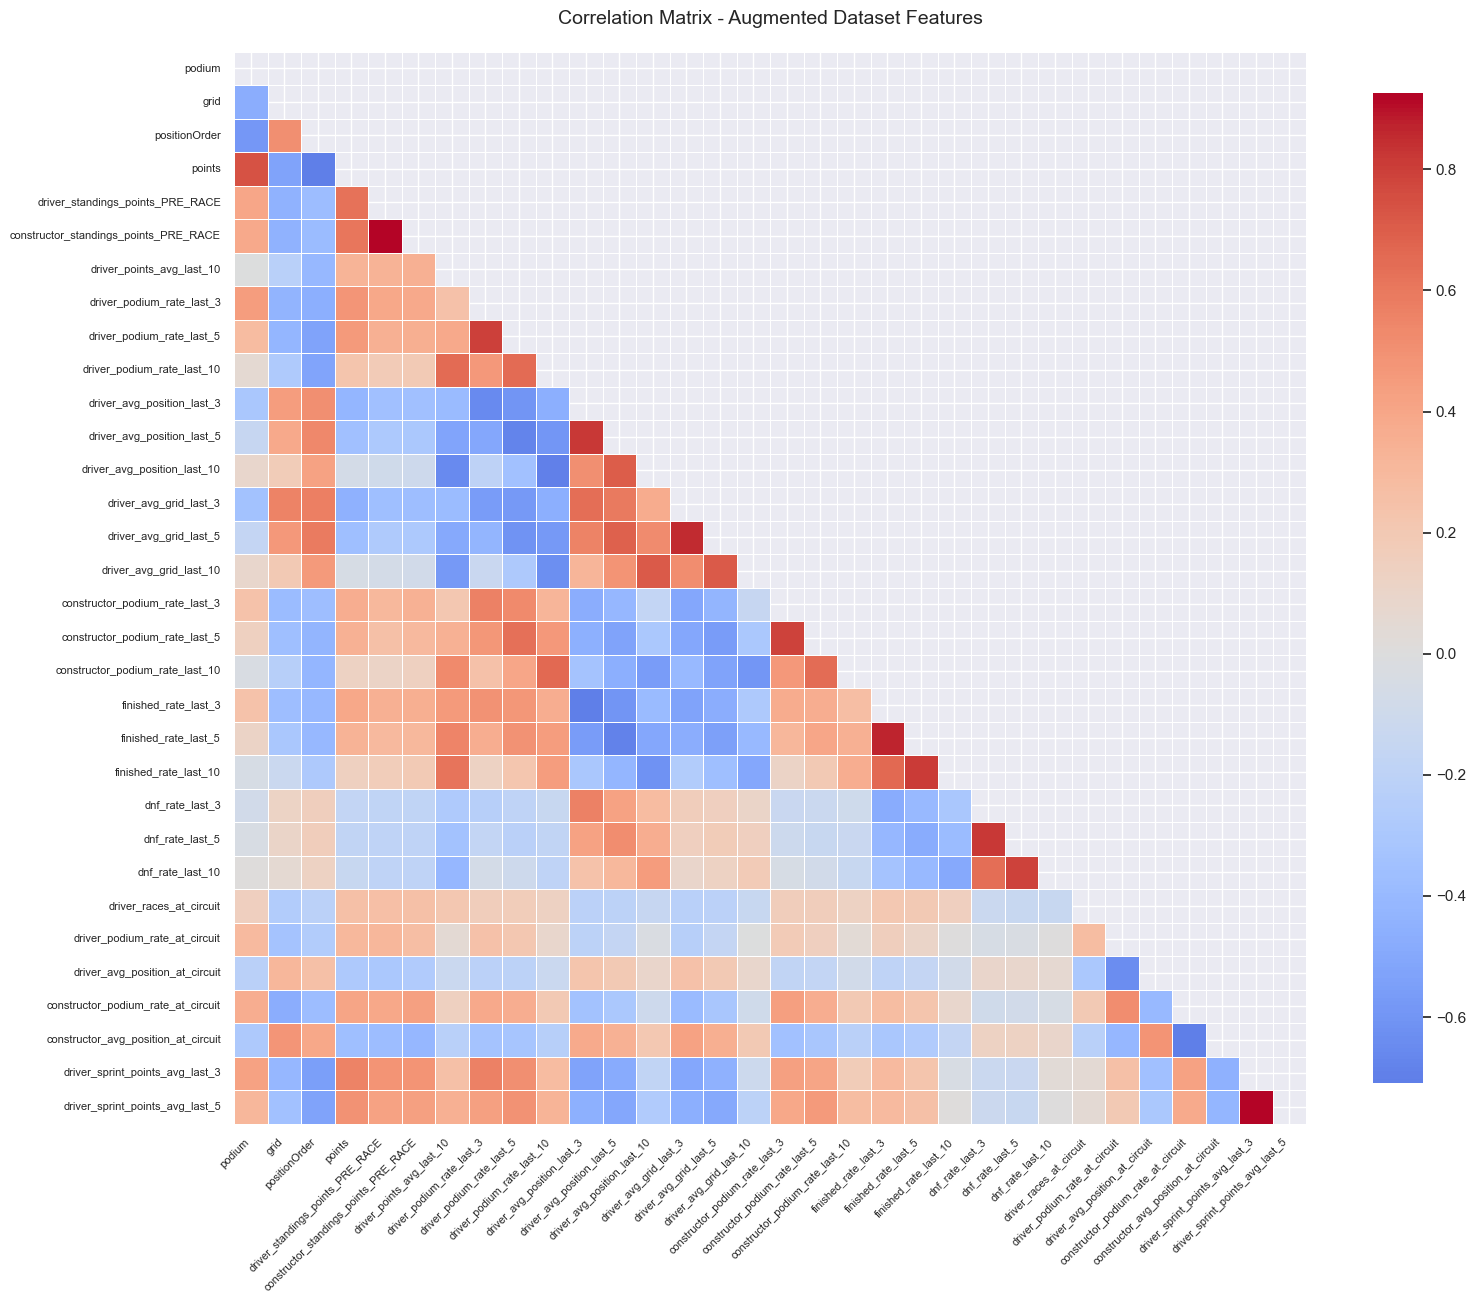


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)
These features may be redundant - consider keeping only one

driver_sprint_points_avg_last_3          <-> driver_sprint_points_avg_last_5          :  0.927
driver_standings_points_PRE_RACE         <-> constructor_standings_points_PRE_RACE    :  0.924
finished_rate_last_3                     <-> finished_rate_last_5                     :  0.875
driver_avg_grid_last_3                   <-> driver_avg_grid_last_5                   :  0.853
driver_avg_position_last_3               <-> driver_avg_position_last_5               :  0.823
dnf_rate_last_3                          <-> dnf_rate_last_5                          :  0.821
finished_rate_last_5                     <-> finished_rate_last_10                    :  0.810
driver_podium_rate_last_3                <-> driver_podium_rate_last_5                :  0.796
constructor_podium_rate_last_3           <-> constructor_podium_rate_last_5           :  0.789
dnf_rate_last_5                        

In [13]:
# Select key numeric features for correlation analysis
# Focus on new features and important predictors
key_features = [
    # Target
    'podium',
    # Original strong predictors
    'grid', 'positionOrder', 'points',
    # Pre-race standings
    'driver_standings_points_PRE_RACE', 'constructor_standings_points_PRE_RACE',
    # Rolling points
    'driver_points_avg_last_10',
    # Driver rolling features
    'driver_podium_rate_last_3', 'driver_podium_rate_last_5', 'driver_podium_rate_last_10',
    'driver_avg_position_last_3', 'driver_avg_position_last_5', 'driver_avg_position_last_10',
    'driver_avg_grid_last_3', 'driver_avg_grid_last_5', 'driver_avg_grid_last_10',
    # Constructor rolling features
    'constructor_podium_rate_last_3', 'constructor_podium_rate_last_5', 'constructor_podium_rate_last_10',
    # Status rates
    'finished_rate_last_3', 'finished_rate_last_5', 'finished_rate_last_10',
    'dnf_rate_last_3', 'dnf_rate_last_5', 'dnf_rate_last_10',
    # Circuit features
    'driver_races_at_circuit',
    'driver_podium_rate_at_circuit', 'driver_avg_position_at_circuit',
    'constructor_podium_rate_at_circuit', 'constructor_avg_position_at_circuit',
    # Season trends
    'driver_position_trend_season',
    # Sprint features
    'driver_sprint_points_avg_last_3', 'driver_sprint_points_avg_last_5',
]

# Filter to features that exist in the dataset
available_features = [f for f in key_features if f in master.columns]
numeric_available = [f for f in available_features if master[f].dtype in [np.int64, np.float64]]

print(f"Features selected for correlation analysis: {len(numeric_available)}")
print(f"Features: {', '.join(numeric_available[:10])}...")

# Calculate correlation matrix
if len(numeric_available) > 1:
    feature_corr = master[numeric_available].corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(feature_corr, dtype=bool))
    
    # Plot correlation heatmap
    plt.figure(figsize=(16, 14))
    sns.heatmap(feature_corr, mask=mask, annot=False, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                xticklabels=feature_corr.columns, yticklabels=feature_corr.columns)
    plt.title('Correlation Matrix - Augmented Dataset Features', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs (excluding self-correlations and podium)
    high_corr_pairs = []
    for i in range(len(feature_corr.columns)):
        for j in range(i+1, len(feature_corr.columns)):
            feat1 = feature_corr.columns[i]
            feat2 = feature_corr.columns[j]
            # Skip if either is podium (we want to see correlations WITH podium, not between features)
            if feat1 == 'podium' or feat2 == 'podium':
                continue
            corr_val = feature_corr.iloc[i, j]
            if abs(corr_val) > 0.7:  # Threshold for high correlation
                high_corr_pairs.append({
                    'feature1': feat1,
                    'feature2': feat2,
                    'correlation': corr_val
                })
    
    # Sort by absolute correlation
    high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)
    
    print("\n" + "="*70)
    print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)")
    print("="*70)
    print("These features may be redundant - consider keeping only one\n")
    
    if high_corr_pairs:
        for pair in high_corr_pairs:
            print(f"{pair['feature1']:40s} <-> {pair['feature2']:40s} : {pair['correlation']:6.3f}")
        
        print(f"\nTotal highly correlated pairs found: {len(high_corr_pairs)}")
        print("\nRecommendations:")
        print("- Consider removing one feature from each highly correlated pair")
        print("- Or create composite features that capture the relationship")
        print("- Keep the feature that is more interpretable or has stronger predictive power")
    else:
        print("No highly correlated pairs found (|r| > 0.7)")
        print("This is good - features are relatively independent")
    
    # Correlations with podium
    if 'podium' in feature_corr.columns:
        podium_corr = feature_corr['podium'].drop('podium').abs().sort_values(ascending=False)
        
        print("\n" + "="*70)
        print("TOP CORRELATIONS WITH PODIUM")
        print("="*70)
        print("\nTop 15 features most correlated with podium:")
        for feat, corr in podium_corr.head(15).items():
            actual_corr = feature_corr.loc[feat, 'podium']
            direction = "positive" if actual_corr > 0 else "negative"
            print(f"  {feat:45s} : {actual_corr:6.3f} ({direction})")
        
        print("\nInterpretation:")
        print("- Positive correlation: Higher values associated with higher podium probability")
        print("- Negative correlation: Higher values associated with lower podium probability")
        print("- For position-related features: Lower position = better, so negative correlation is expected")
else:
    print("Not enough numeric features available for correlation analysis")


### Correlation Analysis Summary

**Key Findings:**
1. **Rolling features with similar windows** (e.g., `driver_podium_rate_last_3` vs `driver_podium_rate_last_5`) will be highly correlated - this is expected and acceptable as they capture different time horizons.

2. **Pre-race standings vs rolling averages** - These may be correlated but capture different information:
   - Pre-race standings = cumulative total points
   - Rolling averages = recent form (last N races)

3. **Status rates** - `finished_rate` and `dnf_rate` should be negatively correlated (as they're complementary).

4. **Circuit features** - Should be relatively independent of rolling features as they capture circuit-specific expertise.

**Recommendations:**
- Keep features with different window sizes (3, 5, 10) as they capture different time horizons
- Monitor correlations between pre-race standings and rolling averages - may want to keep both or create a ratio
- Use feature importance from model training to guide final feature selection
